In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
from torchvision.models import vgg19
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import warnings
random.seed(42)
warnings.filterwarnings("ignore")

In [2]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [3]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
cuda = torch.cuda.is_available()
hr_height = 256

In [4]:
cuda

False

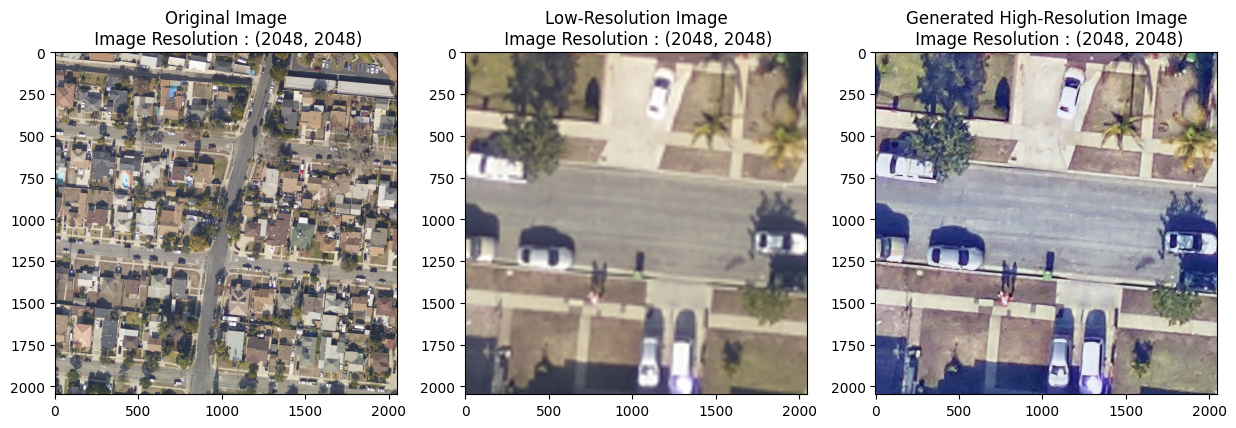

In [5]:
# Load Model Check Point and pridict the image

generator = GeneratorResNet()
generator.load_state_dict(torch.load("saved_models/generator.pth", map_location=torch.device('cpu')))
generator.eval()

# Prepare the single image for testing
image_path = "test_images/test_image.jpg"  # Replace with the path to your image
original_image = Image.open(image_path)
width, height = original_image.size   # Get dimensions
new_width,new_height,offset = 256,256,256*2
left = (width - new_width + offset)/2
top = (height - new_height + offset)/2
right = (width + new_width + offset)/2
bottom = (height + new_height + offset)/2

# Crop the center of the image
image = original_image.crop((left, top, right, bottom))

transform = transforms.Compose([
    transforms.Resize((hr_height, hr_height), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
input_image = transform(image).unsqueeze(0)
if cuda:
    input_image = input_image

# Generate high-resolution output
with torch.no_grad():
    output_image = generator(input_image)
# Convert the generated output to a NumPy array and transpose it
output_image = output_image.squeeze(0).cpu().numpy().transpose((1, 2, 0))
output_image = (output_image + 1) / 2.0  # Unnormalize the image
output_image = Image.fromarray((output_image * 255).astype(np.uint8))
transform = transforms.Compose([
    transforms.Resize((hr_height//2, hr_height//2), Image.BICUBIC),
])
image = transform(image)
transform = transforms.Compose([
    transforms.Resize((height, height), Image.BICUBIC),
])
image = transform(image)
output_image = transform(output_image)
# image.show()
# Display the original low-resolution image and the generated high-resolution image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title(f"Original Image\n Image Resolution : {original_image.size}")
axes[1].imshow(image)
axes[1].set_title(f"Low-Resolution Image\n Image Resolution : {image.size}")
axes[2].imshow(output_image)
axes[2].set_title(f"Generated High-Resolution Image\n Image Resolution : {output_image.size}")
plt.show()

original_image.show(title="Original Image")
image.show(title="Low-Resolution Image")
output_image.show(title="Generated High-Resolution Image")

output_image.save("output_images/high_res_generated.png")
image.save("output_images/low_res_input.png")